# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW01] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from typing import NoReturn, Tuple, List

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """

    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : np.array
        Матрица признаков опухолей.
    y : np.array
        Вектор бинарных меток, 0 соответствует доброкачественной опухоли (B),
        1 --- злокачественной (M).


    """
    df = pd.read_csv(path_to_csv)
    df["label"] = df["label"].map({"M" : 1, "B" : 0})
    df = df.sample(frac=1)
    return df.drop("label", axis=1).values, df["label"].values


def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : np.array
        Матрица признаков сообщений.
    y : np.array
        Вектор бинарных меток, 
        1 если сообщение содержит спам, 0 если не содержит.
    
    """
    df = pd.read_csv(path_to_csv).sample(frac=1)
    return df.drop("label", axis=1).values, df["label"].values

In [3]:
X, y = read_cancer_dataset("cancer.csv")

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [4]:
def train_test_split(X: np.array, y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    """

    Parameters
    ----------
    X : np.array
        Матрица признаков.
    y : np.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : np.array
        Матрица признаков для train выборки.
    y_train : np.array
        Вектор меток для train выборки.
    X_test : np.array
        Матрица признаков для test выборки.
    y_test : np.array
        Вектор меток для test выборки.

    """
    split_idx = round(ratio * y.shape[0])
    return  X[:split_idx], y[:split_idx], X[split_idx:], y[split_idx:]

In [5]:
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [6]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:
    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """
    unique_classes = np.unique(y_true)
    recall, precision = [], []

    accuracy = np.sum(y_pred == y_true) / y_true.shape[0]
    for cl in unique_classes:
        cls_true = y_true == cl
        cls_pred = y_pred == cl

        tp = np.sum(cls_pred[cls_true])
        fp = np.sum(cls_pred[~ cls_true])
        fn = np.sum(~ cls_pred[cls_true])

        recall.append(tp / (tp + fn))
        precision.append(tp / (tp + fp))

    return np.array(precision), np.array(recall), accuracy


Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [7]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [8]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [9]:
class StdScaler:
    def __init__(self, type: str = "std"):
        self.mean = None
        self.std = None

    def fit(self, X: np.ndarray):
        self.mean = X.mean(axis=0)
        self.std = X.std(axis=0)
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        return (X - self.mean) / self.std

    def fit_transform(self, X: np.ndarray):
        return self.fit(X).transform(X)

In [10]:
class Node:
    def __init__(self, value: np.ndarray = None, feature_idx: int = None, depth: int = 0, median: float = None, left = None, right = None):
        self.value = value
        self.feature_idx = feature_idx
        self.depth = depth
        self.median = median
        self.left = left
        self.right = right

    def is_leaf(self) -> bool:
        return self.left is None and self.right is None

    def knn(self, x: np.ndarray, k: int = 1) -> np.ndarray:
        if self.is_leaf():
            tmp = np.hstack((self.value[:, 0].reshape(-1, 1), np.linalg.norm(self.value[:, 1:] - x, axis=1).reshape(-1, 1)))
            if k < self.value.shape[0]:
                tmp = tmp[np.argpartition(tmp[:, 1], k - 1)]
            return tmp[:k, :]
        else:
            raise ValueError("No data for non-leaf node")

In [11]:
class KDTree:
    def __init__(self, X: np.array, leaf_size: int = 40):
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области, 
            в которых не меньше leaf_size точек).

        Returns
        -------

        """
        self.leaf_size = leaf_size
        self.dim = X.shape[1]
        self.X = np.hstack((np.arange(X.shape[0]).reshape(-1, 1), X))  # added indices as 0th col
        self.root = self._build_tree(self.X)

    # def _build_tree(self, X, depth: int = 0):
    #     idx = depth % self.dim + 1
    
    #     X_ = X[:, idx]
    #     m = np.median(X_)
    #     X_left, X_right = X[X_ < m], X[X_ >= m]  #? better in mask
    
    #     # leaf
    #     if X_left.shape[0] < self.leaf_size or X_right.shape[0] < self.leaf_size:
    #         return Node(value = X, depth = depth)
    
    #     # non-leaf node -> split
    #     return Node(median = m,
    #                 left = self._build_tree(X_left, depth + 1),
    #                 right = self._build_tree(X_right, depth + 1),
    #                 depth = depth,
    #                 feature_idx = idx)

    def _build_tree(self, X, depth: int = 0):
        idx_init = depth % self.dim

        for i in range(self.dim - 1):
            if X.shape[0] // 2 < self.leaf_size:
                break
            idx = (idx_init + i) % self.dim + 1

            X_ = X[:, idx]
            m = np.median(X_)
            X_left, X_right = X[X_ < m], X[X_ >= m]  #? better in mask

            if X_left.shape[0] >= 2 * self.leaf_size and X_right.shape[0] >= 2 * self.leaf_size:
                return Node(median = m,
                            left = self._build_tree(X_left, depth + 1),
                            right = self._build_tree(X_right, depth + 1),
                            depth = depth,
                            feature_idx = idx)

        return Node(value = X, depth = depth)

    def query(self, X: np.array, k: int = 1) -> List[List]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно найти ближайших соседей.
        k : int
            Число ближайших соседей.

        Returns
        -------
        list[list]
            Список списков (длина каждого списка k): 
            индексы k ближайших соседей для всех точек из X.

        """
        ans = np.zeros(shape=(X.shape[0], k))
        for idx, x in enumerate(X):
            tmp = self._single_query(x, k, self.root)
            ans[idx] = tmp[np.argsort(tmp[:, 1])][:, 0]

        return ans

    def _single_query(self, x: np.ndarray, k: int, node) -> np.ndarray:
        if node.is_leaf():
            return node.knn(x, k)

        # correct feature idx:
        # x does not contain idx col at 0th col
        # while dataset in KDTree does
        idx = node.feature_idx - 1

        if x[idx] < node.median:
            sibling = node.right
            neighbors = self._single_query(x, k, node.left)
        else:
            sibling = node.left
            neighbors = self._single_query(x, k, node.right)

        if neighbors.shape[0] < k or max(neighbors[:, 1]) >= np.abs(x[idx] - node.median):
            to_merge = self._single_query(x, k, sibling)
            neighbors = self._merge(neighbors, to_merge, k)
        return neighbors

    def _merge(self, a: np.ndarray, b: np.ndarray, k: int):
        tmp = np.concatenate((a, b))
        if k < tmp.shape[0]:
            tmp = tmp[np.argpartition(tmp[:, 1], k - 1)]
        return tmp[:k, :]


Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [12]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [13]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        """

        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.

        """        
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size 
    
    def fit(self, X: np.array, y: np.array) -> NoReturn:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которым строится классификатор.
        y : np.array
            Метки точек, по которым строится классификатор.

        """        
        self.y = y
        self.tree = KDTree(X, self.leaf_size)
        self.classes = np.unique(self.y)
        # return self  # to provide pipe
        
    def predict_proba(self, X: np.array) -> List[np.array]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        list[np.array]
            Список np.array (длина каждого np.array равна числу классов):
            вероятности классов для каждой точки X.

        """
    
        pred = self.y[self.tree.query(X, self.n_neighbors).astype(np.int)]
        ans = np.zeros(shape=(X.shape[0], self.classes.shape[0]))

        for idx, cls in enumerate(self.classes):
            ans[:, idx] = np.sum(pred == cls, axis=1)

        return ans / self.n_neighbors
        
    def predict(self, X: np.array) -> np.array:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        np.array
            Вектор предсказанных классов.
            

        """
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

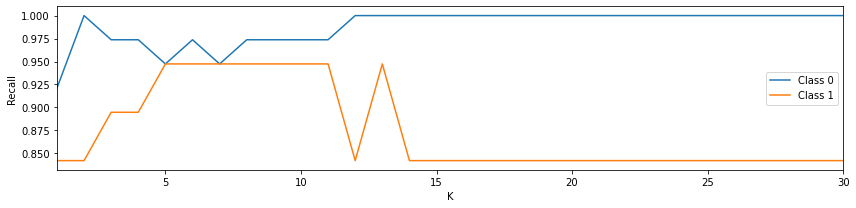

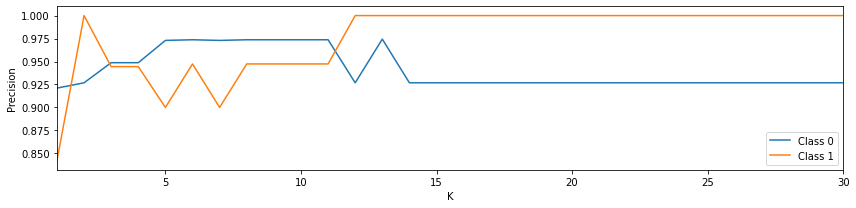

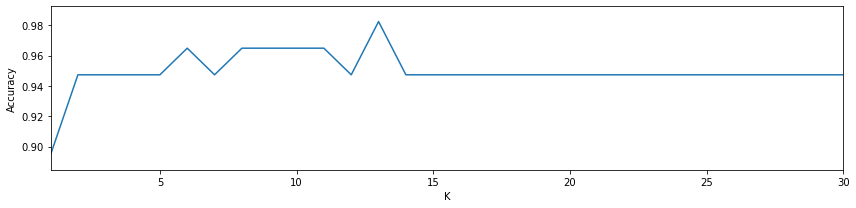

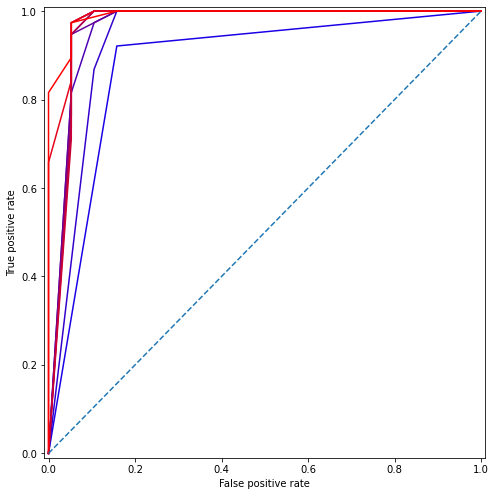

CPU times: user 2.85 s, sys: 159 ms, total: 3.01 s
Wall time: 3.03 s


In [14]:
%%time
scl = "std"
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
scaler = StdScaler(scl)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

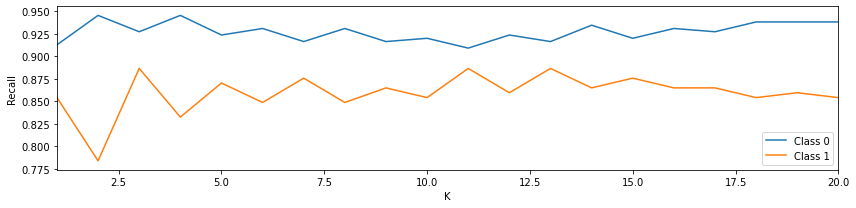

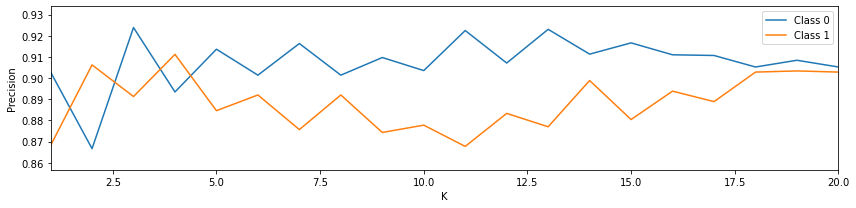

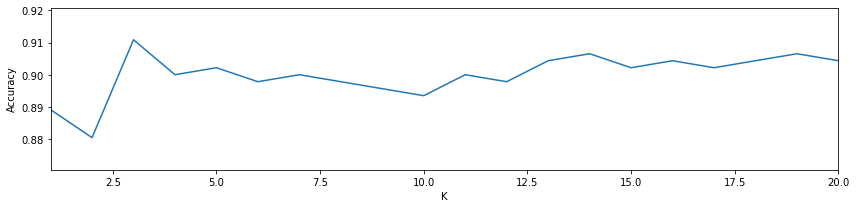

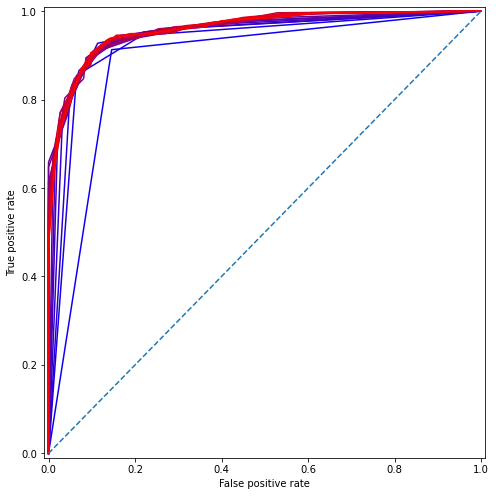

CPU times: user 1min 15s, sys: 812 ms, total: 1min 16s
Wall time: 1min 16s


In [15]:
%%time
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
scaler = StdScaler(scl)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)